In [1]:
import pathlib
import xml.etree.ElementTree as ET

import matplotlib.patheffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


pd.plotting.register_matplotlib_converters()
data_path = pathlib.Path("..\\data")

plot_style = {
    "font.size": 8,
    "font.style": "normal",
    "font.weight": "normal",
    "font.family": "monospace",
    "text.color": "#454545",
    "axes.edgecolor": "#454545",
    "axes.labelcolor": "#454545",
    "axes.linewidth": .4,
    "axes.grid": False,
}

# Read data

In [2]:
root = ET.parse(data_path / "Half-Life_-_WON_Easy.lss").getroot()

In [3]:
runs = (
    pd.DataFrame(
        data=[element.attrib for element in root.find("AttemptHistory").findall("Attempt")]
    )
    .astype({"id": int, "isStartedSynced": bool, "isEndedSynced": bool})
)
runs.loc[:, "started"] = pd.to_datetime(runs.loc[:, "started"])
runs.loc[:, "ended"] = pd.to_datetime(runs.loc[:, "ended"])
runs.head()

,id,started,isStartedSynced,ended,isEndedSynced
0,1,2018-01-17 17:45:30,True,2018-01-17 17:45:38,True
1,2,2018-01-17 17:45:38,True,2018-01-17 17:46:11,True
2,3,2018-01-17 17:46:11,True,2018-01-17 17:47:00,True
3,4,2018-01-17 17:47:05,True,2018-01-17 17:48:11,True
4,5,2018-01-17 17:48:11,True,2018-01-17 17:48:21,True


In [4]:
segments = []
for segment in root.find("Segments").findall("Segment"):
    name = segment.find("Name").text
    for segment_time in segment.find("SegmentHistory").findall("Time"):
        try:
            real_time = pd.to_timedelta(segment_time.find("RealTime").text)
        except AttributeError:
            real_time = np.nan
        try:
            game_time = pd.to_timedelta(segment_time.find("GameTime").text)
        except AttributeError:
            game_time = np.nan
        segments.append(
            {
                "Name": name,
                "id": int(segment_time.attrib["id"]),
                "RealTime": real_time,
                "GameTime": game_time
            }
        )
segments = pd.DataFrame(data=segments)
segments.loc[:, "Name"] = segments.loc[:, "Name"].apply(lambda x: " ".join([val for val in x.lower().split(" ") if len(val) > 0]))
segments.loc[:, "Name"] = pd.Categorical(
    segments.loc[:, "Name"],
    [
        'anomalous materials',
        'unforeseen consequences',
        'office complex',
        '"we\'ve got hostiles"',
        'blast pit',
        'power up',
        'on a rail',
        'apprehension',
        'residue processing',
        'questionable ethics',
        'surface tension',
        '"forget about freeman!"',
        'lambda core',
        'xen',
        "gonarch's lair",
        'interloper',
        'nihilanth'
    ]
)
segments = segments.merge(right=runs, how="inner", on="id").dropna()
segments.head()

,Name,id,RealTime,GameTime,started,isStartedSynced,ended,isEndedSynced
0,anomalous materials,700,00:04:29.376000,00:04:22.567000,2018-02-24 19:54:08,True,2018-02-24 20:39:29,True
1,office complex,700,00:01:18.780000,00:01:17.620000,2018-02-24 19:54:08,True,2018-02-24 20:39:29,True
2,"""we've got hostiles""",700,00:00:17.677000,00:00:16.714000,2018-02-24 19:54:08,True,2018-02-24 20:39:29,True
3,anomalous materials,699,00:04:14.128000,00:04:11.970000,2018-02-24 19:43:25,True,2018-02-24 19:54:08,True
4,office complex,699,00:01:14.105000,00:01:12.081000,2018-02-24 19:43:25,True,2018-02-24 19:54:08,True


# Get statistics by segment
Segment times larger than the 95th percentile of times for each of the segments (aka outliers) were removed. These abnormally long segment times were likely caused by AFK'ing and subsequently continuing a "dead" run.

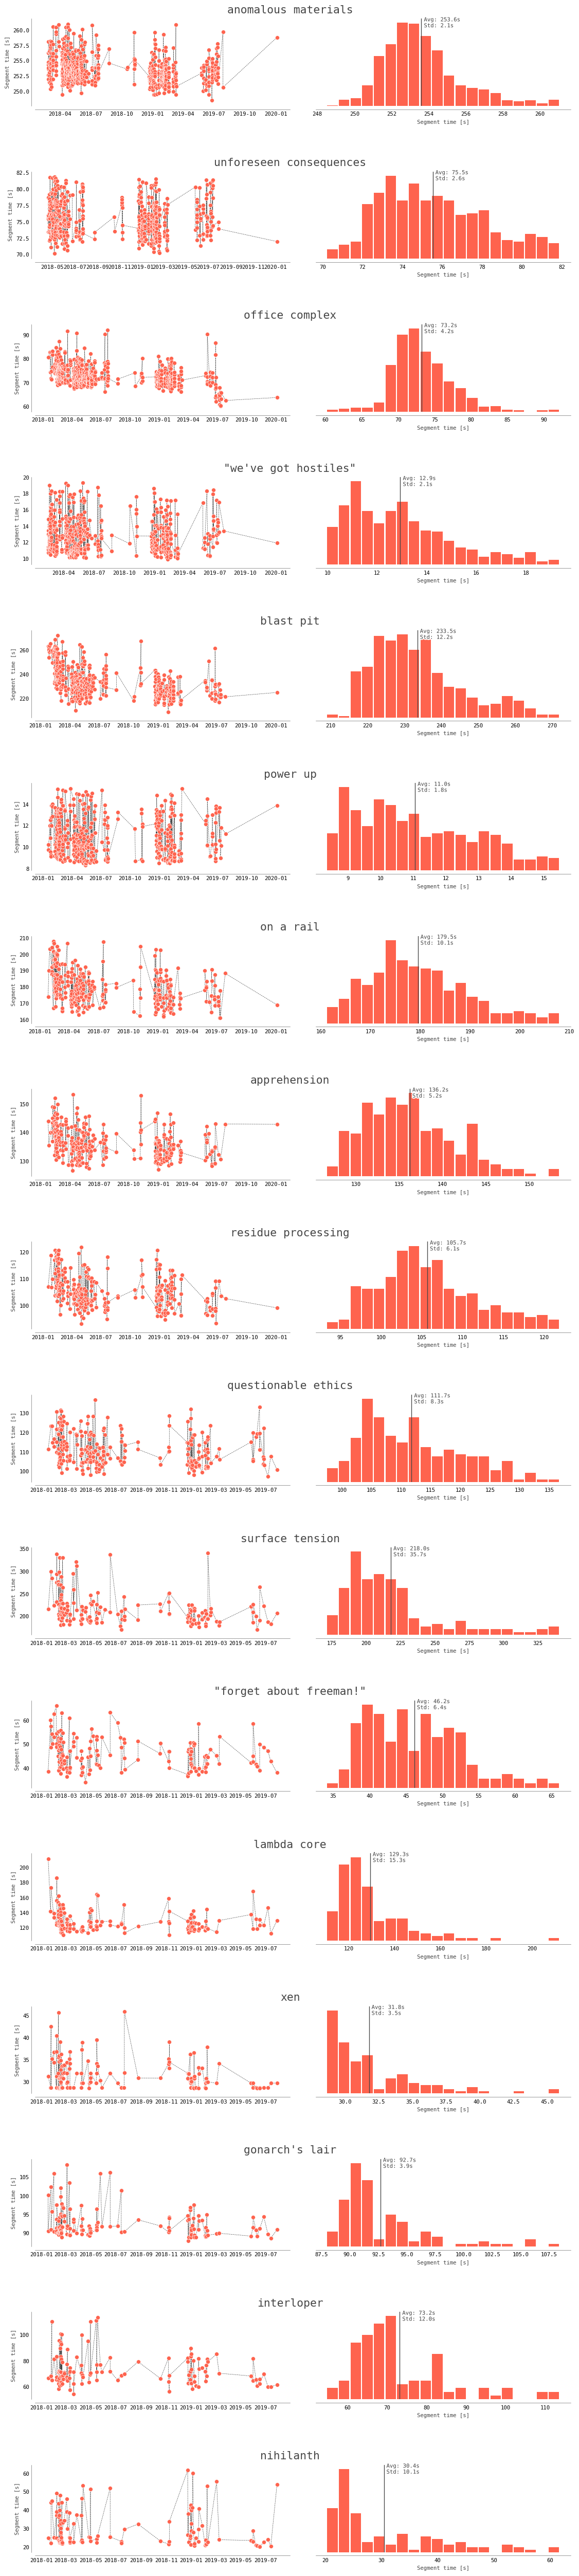

In [5]:
with plt.rc_context(rc=plot_style):
    nrows = len(segments.loc[:, "Name"].unique())
    fig, axes = plt.subplots(
        nrows=nrows, ncols=2, figsize=(14, 4*nrows), dpi=96,
        gridspec_kw=dict(wspace=0.1, hspace=0.75)
    )
    for i, (segment, df) in enumerate(segments.groupby("Name", sort=True)):
        ax1, ax2 = axes[i]
        for ax in [ax1, ax2]:
            ax.spines["right"].set_visible(False)
            ax.spines["top"].set_visible(False)
            ax.spines["bottom"].set_position(("outward", 5))
            ax.tick_params(axis="x", which="both", length=0)
        ax1.spines["left"].set_position(("outward", 5))
        ax1.tick_params(axis="y", which="both", length=0)
        ax2.spines["left"].set_visible(False)
        ax2.tick_params(axis="y", which="both", labelleft=False, length=0)
        
        df_sorted = df.copy(deep=True).sort_values("started")
        df_sorted = df_sorted.loc[df_sorted.loc[:, "GameTime"] <= np.quantile(df_sorted.loc[:, "GameTime"], 0.95)]
        ax1.plot(
            df_sorted.loc[:, "started"], df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9,
            color="#454545", ls="--", lw=.5, zorder=5
        )
        ax1.scatter(
            df_sorted.loc[:, "started"], df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9,
            marker="o", facecolor="#FE634E", edgecolor="w", lw=0.5, zorder=10
        )
        ax1.set_ylabel("Segment time [s]")

        ax2.hist(
            df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9,
            bins=20, density=True, rwidth=0.9, facecolor="#FE634E", edgecolor="None", lw=0, zorder=10
        )
        mean = np.mean(df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9)
        std = np.std(df_sorted.loc[:, "GameTime"].astype(np.timedelta64).astype(float) / 1e9)
        ax2.axvline(mean, lw=1, ls="-", color="#454545", zorder=15)
        ax2.text(
            x=mean+np.diff(ax2.get_xlim())[0] * 0.01,
            y=ax2.get_ylim()[1] * 0.9,
            s=f"Avg: {mean:.1f}s\nStd: {std:.1f}s", zorder=20, fontsize=8, fontfamily="monospace",
            path_effects=[matplotlib.patheffects.withStroke(linewidth=3, foreground="w")]
        )
        ax2.set_xlabel("Segment time [s]")

        title = ax1.set_title(f"{segment}", ha="center", va="center", fontsize=16)
        title.set_position((1, 1.05))

# Analysis of run times
Get a distribution of run time and estimate probabilities of reaching a specific time in a random run. Perform a Monte Carlo simulation by sampling `n` times from the known segment times:

In [6]:
n = 1_000_000  # number of samples
cutoff = 40  # duration in minutes, beyond which a run makes no sense (discard unrealistic run times)

run_times = np.array(
    [
        np.random.choice(df.loc[:, "GameTime"].values.astype(float) / 1e9, size=n, replace=True)
        for _, df in segments.groupby("Name", sort=False)
    ]
).sum(axis=0) / 60
run_times = run_times[run_times < cutoff]
pdf, bin_edges = np.histogram(run_times, bins=30)
cdf = np.cumsum(pdf) / n
bin_edges = np.convolve(bin_edges, [0.5, 0.5], mode='valid')

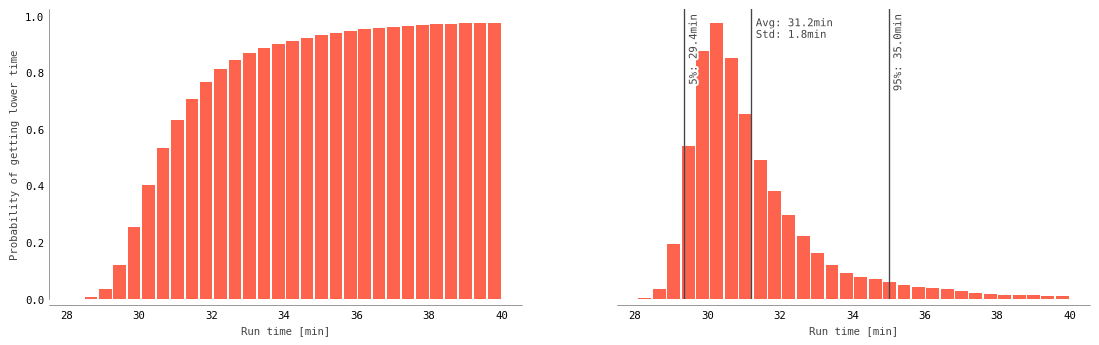

In [7]:
with plt.rc_context(rc=plot_style):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4), dpi=96)
    for ax in [ax1, ax2]:
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_position(("outward", 5))
        ax.tick_params(axis="x", which="both", length=0)
    ax1.tick_params(axis="y", which="both", length=0)
    ax2.spines["left"].set_visible(False)
    ax2.tick_params(axis="y", which="both", labelleft=False, length=0)
    
    ax1.bar(
        bin_edges, cdf,
        width=(bin_edges.max() - bin_edges.min()) / len(bin_edges) * 0.9,
        facecolor="#FE634E", edgecolor="None", lw=0, zorder=10
    )
    ax1.set_xlabel("Run time [min]")
    ax1.set_ylabel("Probability of getting lower time")
    
    ax2.hist(run_times, bins=30, density=True, rwidth=0.9, facecolor="#FE634E", edgecolor="None", lw=0, zorder=10)
    mean = run_times.mean()
    std = run_times.std()
    ax2.axvline(mean, lw=1, ls="-", color="#454545", zorder=15)
    ax2.text(
        x=mean+np.diff(ax2.get_xlim())[0] * 0.01,
        y=ax2.get_ylim()[1] * 0.9,
        s=f"Avg: {mean:.1f}min\nStd: {std:.1f}min", zorder=20, fontsize=8, fontfamily="monospace",
        path_effects=[matplotlib.patheffects.withStroke(linewidth=3, foreground="w")]
    )
    ax2.set_xlabel("Run time [min]")
    
    for percentile in [5, 95]:
        ax2.axvline(np.percentile(run_times, percentile), lw=1, ls="-", color="#454545", zorder=15)
        ax2.text(
            x=np.percentile(run_times, percentile)+np.diff(ax2.get_xlim())[0] * 0.02,
            y=ax2.get_ylim()[1] * 0.98,
            s=f"{percentile:d}%: {np.percentile(run_times, percentile):.1f}min",
            ha="center", va="top", zorder=20, fontsize=8, fontfamily="monospace", rotation=90,
            path_effects=[matplotlib.patheffects.withStroke(linewidth=3, foreground="w")]
        )

# Optimization of pace
Get distribution of possible total run times given current pace and segment. Provides information required to make decision whether to continue run or not. The way these times should be interpreted is that as long as current run time is lower than the stop time on a given segment, there is at least a 5% probability of beating target time.

In [8]:
n = 1_000_000  # number of samples
target_time = 35  # minutes
percentile = 5  # lowest probability in % of beating target time, below which run is not feasible

samples = np.array(
    [
        np.random.choice(df.loc[:, "GameTime"].values.astype(float) / 1e9, size=n, replace=True)
        for _, df in segments.groupby("Name", sort=True)
    ]
)
stop_times = target_time * 60 - np.array([np.percentile(samples[i:].sum(axis=0), percentile) for i in range(len(segments.Name.unique()))])
stop_times = pd.DataFrame(
    data=[pd.to_timedelta(f"{st:.0f}S") for st in stop_times],
    index=pd.Index(segments.Name.cat.categories, name="Segment"),
    columns=["Stop time [min]"]
)
stop_times

,Stop time [min]
Segment,
anomalous materials,00:05:38
unforeseen consequences,00:09:52
office complex,00:11:08
"""we've got hostiles""",00:12:22
blast pit,00:12:35
power up,00:16:26
on a rail,00:16:38
apprehension,00:19:36
residue processing,00:21:52
